# Generowanie reguł asocjacyjnych - Laboratorium Danologia

## Sprawozdanie z analizy danych transakcyjnych supermarketu

**Autor:** Aleksander Stepaniuk     
**Nr. Indeksu:** 272644     
**Data:** 30 października 2025      

---

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings('ignore')

print("załadowano biblioteki")

załadowano biblioteki


## 1. Wczytywanie i przygotowanie danych

Wczytujemy dane z pliku `supermarket.csv`. Każdy wiersz reprezentuje koszyk zakupów zawierający różne kategorie produktów oraz jako ostatni rekord - wartość rachunku (high/low).

Usuwamy produkty o nazwie rozpoczynającej się od "department"

In [22]:
transactions = []
bill_values = []  # przechowujemy wartości rachunku (high/low)

with open('supermarket.csv', 'r') as file:
    for line in file:
        # pozbywamy się białych znaków i dzielimy po przecinkach
        items = [item.strip() for item in line.strip().split(',')]
        
        # ostatni element to wartość rachunku (high/low)
        bill_value = items[-1]
        bill_values.append(bill_value)
        
        # produkty to wszystkie elementy oprócz ostatniego
        products = items[:-1]
        
        # usuwamy produkty typu "department<id>"
        products = [item for item in products if not item.startswith('department')]
        transactions.append(products)

print(f"Liczba transakcji: {len(transactions)}")
print(f"\nRozkład wartości rachunku:")
print(f"  High: {bill_values.count('high')}")
print(f"  Low: {bill_values.count('low')}")
print(f"\nPrzykładowe transakcje:")
for i in range(min(3, len(transactions))):
    print(f"Transakcja {i+1} - Rachunnek: {bill_values[i]}, Produkty ({len(transactions[i])}): {transactions[i][:5]}...")

Liczba transakcji: 4627

Rozkład wartości rachunku:
  High: 1679
  Low: 2948

Przykładowe transakcje:
Transakcja 1 - Rachunnek: high, Produkty (24): ['baby needs', 'bread and cake', 'baking needs', 'juice-sat-cord-ms', 'biscuits']...
Transakcja 2 - Rachunnek: low, Produkty (14): ['canned fish-meat', 'canned fruit', 'canned vegetables', 'sauces-gravy-pkle', 'deod-disinfectant']...
Transakcja 3 - Rachunnek: low, Produkty (16): ['bread and cake', 'baking needs', 'juice-sat-cord-ms', 'biscuits', 'canned fruit']...


## 2. Kodowanie danych w formacie One-Hot

Dane transakcyjne muszą zostać przekształcone do formatu binarnego (one-hot encoding), gdzie każda kolumna reprezentuje produkt, a wartość 1 oznacza jego obecność w transakcji.

In [23]:
# kodowanie transakcji (tylko produkty, bez wartości rachunku)
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# dodajemy kolumnę z wartością rachunku
df['bill_value'] = bill_values

# sprawdzamy czy 'high' i 'low' nie są w kolumnach produktów
if 'high' in df.columns or 'low' in df.columns:
    print("--- UWAGA: 'high' lub 'low' wykryto jako produkt - coś poszło nie tak :c")
else:
    print("jest ok, 'high' i 'low' nie są traktowane jako produkty")

print(f"\nWymiary macierzy: {df.shape}")
print(f"Liczba unikalnych produktów (bez high/low): {len(df.columns) - 1}")  # -1 bo bill_value
print(f"\nPierwsze 5 wierszy i 10 kolumn produktów:")
print(df.iloc[:5, :10])
print(f"\nWartości rachunku dla pierwszych 5 transakcji:")
print(df['bill_value'].head())

jest ok, 'high' i 'low' nie są traktowane jako produkty

Wymiary macierzy: (4627, 101)
Liczba unikalnych produktów (bez high/low): 100

Pierwsze 5 wierszy i 10 kolumn produktów:
   750ml red imp  750ml red nz  750ml white imp  750ml white nz  baby needs  \
0          False         False            False            True        True   
1          False         False            False           False       False   
2          False         False            False           False       False   
3          False         False            False           False       False   
4          False         False            False           False       False   

   bake off products  baking needs   beef  beverages hot  biscuits  
0              False          True  False          False      True  
1              False         False  False          False     False  
2              False          True   True          False      True  
3              False          True   True          False      True  
4 

---

## Zad 1: Najliczniejszy zbiór częsty o minimalnym wsparciu 20%

- znaleźć najliczniejszy zbiór częsty (największą liczbę elementów) spośród zbiorów o wsparciu >= 20%, w przypadku kilku równolicznych zbiorów, wybrać ten o największym wsparciu

In [30]:
# generowanie zbiorów częstych o minimalnym wsparciu 20% (tylko produkty)
df_products = df.drop(columns=['bill_value'])

frequent_itemsets_20 = apriori(df_products, min_support=0.20, use_colnames=True)

# obliczenie liczby elementów w każdym zbiorze
frequent_itemsets_20['length'] = frequent_itemsets_20['itemsets'].apply(lambda x: len(x))

# znalezienie maksymalnej długości
max_length = frequent_itemsets_20['length'].max()

# filtrowanie do najdłuższych zbiorów
longest_itemsets = frequent_itemsets_20[frequent_itemsets_20['length'] == max_length]

# wybranie zbioru o największym wsparciu
best_itemset = longest_itemsets.loc[longest_itemsets['support'].idxmax()]

print(f"Maksymalna długość zbioru częstego: {max_length}")
print(f"\nNajliczniejszy zbiór częsty o największym wsparciu:")
print(f"Produkty: {list(best_itemset['itemsets'])}")
print(f"Wsparcie (procent): {best_itemset['support']*100:.2f}%")

Maksymalna długość zbioru częstego: 5

Najliczniejszy zbiór częsty o największym wsparciu:
Produkty: ['vegetables', 'fruit', 'bread and cake', 'baking needs', 'milk-cream']
Wsparcie (procent): 20.29%


### Interpretacja wyników Zad 1:

Znaleziony zbiór częsty reprezentuje kombinację produktów (`['vegetables', 'fruit', 'bread and cake', 'baking needs', 'milk-cream']`), która pojawia się razem w co najmniej 20% wszystkich transakcji. 

Produkty w zbiorze to podstawowe artykuły spożywcze, które klienci często kupują razem podczas zakupów.

- im większa liczba produktów w zbiorze częstym, tym silniejszy dany wzorzec zakupowy
- wyższe wsparcie wskazuje, że klienci często kupują te produkty razem

---

## Zadanie 2: Histogram występowania produktów

częstotliwość występowania 10 najpopularniejszych produktów w bazie

Top 10 najczęściej występujących produktów:
bread and cake       3330
fruit                2962
vegetables           2961
milk-cream           2939
baking needs         2795
frozen foods         2717
biscuits             2605
juice-sat-cord-ms    2463
party snack foods    2330
margarine            2288
dtype: int64

Całkowita liczba transakcji: 4627


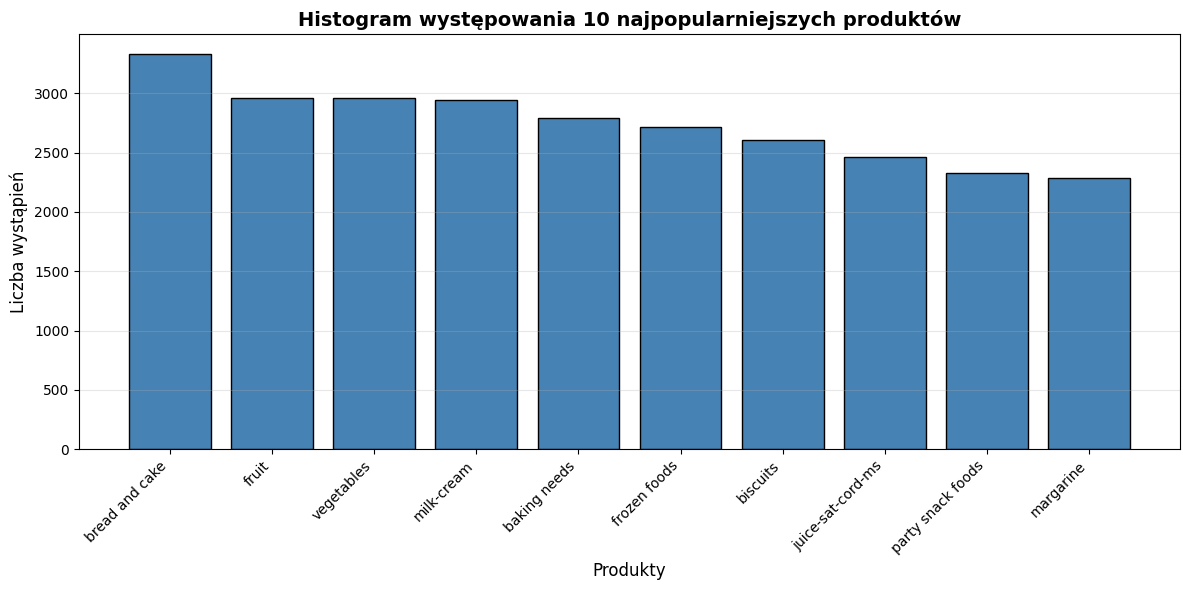


Wsparcie (procent transakcji) dla top 10 produktów:
bread and cake: 71.97%
fruit: 64.02%
vegetables: 63.99%
milk-cream: 63.52%
baking needs: 60.41%
frozen foods: 58.72%
biscuits: 56.30%
juice-sat-cord-ms: 53.23%
party snack foods: 50.36%
margarine: 49.45%


In [25]:
# obliczenie częstotliwości występowania każdego produktu (bez 'bill_value')
df_products = df.drop(columns=['bill_value'])
product_frequency = df_products.sum().sort_values(ascending=False)

# wybranie top 10
top_10_products = product_frequency.head(10)

# wyświetlenie wartości
print("Top 10 najczęściej występujących produktów:")
print(top_10_products)
print(f"\nCałkowita liczba transakcji: {len(df)}")

# utworzenie histogramu
plt.figure(figsize=(12, 6))
plt.bar(range(len(top_10_products)), top_10_products.values, color='steelblue', edgecolor='black')
plt.xlabel('Produkty', fontsize=12)
plt.ylabel('Liczba wystąpień', fontsize=12)
plt.title('Histogram występowania 10 najpopularniejszych produktów', fontsize=14, fontweight='bold')
plt.xticks(range(len(top_10_products)), top_10_products.index, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# obliczenie wsparcia dla top 10
print("\nWsparcie (procent transakcji) dla top 10 produktów:")
for product, count in top_10_products.items():
    support_pct = (count / len(df)) * 100
    print(f"{product}: {support_pct:.2f}%")

---

## Zadanie 3: Reguły asocjacyjne o minimalnym wsparciu 25% i ufności 0.70

In [31]:
# generowanie zbiorów częstych o minimalnym wsparciu 25% (tylko produkty)
df_products = df.drop(columns=['bill_value'])

frequent_itemsets_25 = apriori(df_products, min_support=0.25, use_colnames=True)

print(f"Liczba zbiorów częstych o wsparciu ≥ 25%: {len(frequent_itemsets_25)}")

# generowanie reguł o minimalnej ufności 0.70
rules = association_rules(frequent_itemsets_25, metric="confidence", min_threshold=0.70)

print(f"Liczba reguł o ufności ≥ 0.70: {len(rules)}")

# wypisz ile jest reguł z danym consequent (z każdym):
consequent_counts = {}
for idx, rule in rules.iterrows():
    for consequent in rule['consequents']:
        if consequent not in consequent_counts:
            consequent_counts[consequent] = 0
        consequent_counts[consequent] += 1

print("\nLiczba reguł dla każdego consequent:")
for consequent, count in consequent_counts.items():
    print(f"{consequent}: {count}")

if len(rules) > 0:
    # sortowanie reguł według liftu
    rules_sorted = rules.sort_values('lift', ascending=False)

    # wyświetlenie wszystkich reguł
    print("\n" + "="*100)
    print("WSZYSTKIE REGUŁY ASOCJACYJNE")
    print("="*100)
    
    for idx, rule in rules_sorted.iterrows():
        print(f"\nReguła {idx + 1}:")
        print(f"  {set(rule['antecedents'])} -> {set(rule['consequents'])}")
        print(f"  Wsparcie: {rule['support']:.4f} ({rule['support']*100:.2f}%)")
        print(f"  Ufność: {rule['confidence']:.4f} ({rule['confidence']*100:.2f}%)")
        print(f"  Lift: {rule['lift']:.4f}")
        print(f"  Wsparcie poprzednika: {rule['antecedent support']:.4f}")
        print(f"  Wsparcie następnika: {rule['consequent support']:.4f}")
else:
    print("\nBrak reguł spełniających kryteria.")

Liczba zbiorów częstych o wsparciu ≥ 25%: 217
Liczba reguł o ufności ≥ 0.70: 192

Liczba reguł dla każdego consequent:
bread and cake: 71
baking needs: 13
vegetables: 38
fruit: 34
milk-cream: 22
frozen foods: 9
biscuits: 5

WSZYSTKIE REGUŁY ASOCJACYJNE

Reguła 89:
  {'party snack foods', 'frozen foods'} -> {'biscuits'}
  Wsparcie: 0.2546 (25.46%)
  Ufność: 0.7446 (74.46%)
  Lift: 1.3226
  Wsparcie poprzednika: 0.3419
  Wsparcie następnika: 0.5630

Reguła 79:
  {'bread and cake', 'party snack foods'} -> {'biscuits'}
  Wsparcie: 0.2823 (28.23%)
  Ufność: 0.7223 (72.23%)
  Lift: 1.2830
  Wsparcie poprzednika: 0.3907
  Wsparcie następnika: 0.5630

Reguła 184:
  {'bread and cake', 'biscuits', 'vegetables'} -> {'fruit'}
  Wsparcie: 0.2628 (26.28%)
  Ufność: 0.8178 (81.78%)
  Lift: 1.2774
  Wsparcie poprzednika: 0.3214
  Wsparcie następnika: 0.6402

Reguła 39:
  {'frozen foods', 'baking needs'} -> {'biscuits'}
  Wsparcie: 0.2844 (28.44%)
  Ufność: 0.7172 (71.72%)
  Lift: 1.2738
  Wsparcie pop

### Interpretacja wyników Zadania 3:

- Znaleziono `217 zbiorów częstych` o wsparciu ≥ 25%
- Wygenerowano `192 reguły asocjacyjne` o ufności ≥ 0.70

Analiza wartościowości reguł:

- im więcej produktów w poprzedniku reguły, tym bardziej szczegółowy wzorzec
- Dopóki lift nie wyróżnia się znacznie, to te popularne produkty i tak będą występować w następniku.
- Elementy się powtarzają w poprzedniku

---

## Zadanie 4: Reguły prowadzące do wysokiej wartości rachunku (X-> {high})

In [27]:
# tworzymy binarną kolumnę 'high' na podstawie bill_value
df_with_high = df_products.copy()
df_with_high['high'] = (df['bill_value'] == 'high').astype(int)

print(f"Sprawdzenie: liczba transakcji z high={df_with_high['high'].sum()}, z low={len(df) - df_with_high['high'].sum()}")

# generowanie zbiorów częstych o minimalnym wsparciu 16%
frequent_itemsets_16 = apriori(df_with_high, min_support=0.16, use_colnames=True)

print(f"\nLiczba zbiorów częstych o wsparciu ≥ 16%: {len(frequent_itemsets_16)}")

# generowanie reguł o minimalnej ufności 0.50
rules_high = association_rules(frequent_itemsets_16, metric="confidence", min_threshold=0.50)

print(f"Liczba reguł o ufności ≥ 0.50: {len(rules_high)}")

# filtrowanie reguł, które mają jako następnik tylko "high"
rules_to_high = rules_high[
    (rules_high['consequents'].apply(lambda x: x == frozenset({'high'})))
]

print(f"Liczba reguł prowadzących do 'high': {len(rules_to_high)}")

if len(rules_to_high) > 0:
    # sortowanie według ufności i liftu
    rules_to_high_sorted = rules_to_high.sort_values(['lift', 'confidence'], ascending=False)
    
    print("\n" + "="*100)
    print("REGUŁY PROWADZĄCE DO WYSOKIEJ WARTOŚCI RACHUNKU (X -> {high})")
    print("="*100)
    
    for idx, rule in rules_to_high_sorted.iterrows():
        print(f"\nReguła {idx + 1}:")
        print(f"  {set(rule['antecedents'])} -> {set(rule['consequents'])}")
        print(f"  Wsparcie: {rule['support']:.4f} ({rule['support']*100:.2f}%)")
        print(f"  Ufność: {rule['confidence']:.4f} ({rule['confidence']*100:.2f}%)")
        print(f"  Lift: {rule['lift']:.4f}")
        print(f"  Wsparcie poprzednika: {rule['antecedent support']:.4f} ({rule['antecedent support']*100:.2f}%)")
        print(f"  Wsparcie następnika (high): {rule['consequent support']:.4f} ({rule['consequent support']*100:.2f}%)")
        
else:
    print("\nBrak reguł spełniających kryteria.")

Sprawdzenie: liczba transakcji z high=1679, z low=2948

Liczba zbiorów częstych o wsparciu ≥ 16%: 1469
Liczba reguł o ufności ≥ 0.50: 5888
Liczba reguł prowadzących do 'high': 144

REGUŁY PROWADZĄCE DO WYSOKIEJ WARTOŚCI RACHUNKU (X -> {high})

Reguła 4018:
  {'biscuits', 'frozen foods', 'tissues-paper prd'} -> {'high'}
  Wsparcie: 0.1604 (16.04%)
  Ufność: 0.6922 (69.22%)
  Lift: 1.9075
  Wsparcie poprzednika: 0.2317 (23.17%)
  Wsparcie następnika (high): 0.3629 (36.29%)

Reguła 3244:
  {'frozen foods', 'baking needs', 'tissues-paper prd'} -> {'high'}
  Wsparcie: 0.1630 (16.30%)
  Ufność: 0.6744 (67.44%)
  Lift: 1.8586
  Wsparcie poprzednika: 0.2416 (24.16%)
  Wsparcie następnika (high): 0.3629 (36.29%)

Reguła 5265:
  {'bread and cake', 'biscuits', 'frozen foods', 'baking needs'} -> {'high'}
  Wsparcie: 0.1604 (16.04%)
  Ufność: 0.6667 (66.67%)
  Lift: 1.8372
  Wsparcie poprzednika: 0.2405 (24.05%)
  Wsparcie następnika (high): 0.3629 (36.29%)

Reguła 3802:
  {'bread and cake', 'biscu

In [ ]:
if len(rules_to_high) > 0:
    print("\n" + "="*100)
    print("ZESTAWIENIE TABELARYCZNE - TOP 10 REGUŁ")
    print("="*100 + "\n")
    
    # Przygotowanie czytelnej tabeli
    display_df = pd.DataFrame({
        'Produkty (X)': rules_to_high_sorted['antecedents'].apply(lambda x: ', '.join(list(x))),
        '->': ['->'] * len(rules_to_high_sorted),
        'Następnik': ['high'] * len(rules_to_high_sorted),
        'Wsparcie': rules_to_high_sorted['support'].apply(lambda x: f"{x:.4f}"),
        'Ufność': rules_to_high_sorted['confidence'].apply(lambda x: f"{x:.4f}"),
        'Lift': rules_to_high_sorted['lift'].apply(lambda x: f"{x:.4f}")
    })
    
    print(display_df.head(10).to_string(index=False))
    print("\n")


ZESTAWIENIE TABELARYCZNE - TOP 10 REGUŁ

                                        Produkty (X) → Następnik Wsparcie Ufność   Lift
           biscuits, frozen foods, tissues-paper prd →      high   0.1604 0.6922 1.9075
       frozen foods, baking needs, tissues-paper prd →      high   0.1630 0.6744 1.8586
bread and cake, biscuits, frozen foods, baking needs →      high   0.1604 0.6667 1.8372
         bread and cake, biscuits, sauces-gravy-pkle →      high   0.1636 0.6594 1.8172
     bread and cake, frozen foods, tissues-paper prd →      high   0.1759 0.6570 1.8105
         bread and cake, biscuits, tissues-paper prd →      high   0.1703 0.6518 1.7962
     bread and cake, frozen foods, sauces-gravy-pkle →      high   0.1710 0.6516 1.7956
     bread and cake, sauces-gravy-pkle, baking needs →      high   0.1712 0.6476 1.7846
                tissues-paper prd, sauces-gravy-pkle →      high   0.1794 0.6434 1.7731
     bread and cake, tissues-paper prd, baking needs →      high   0.1777 0.63

### Interpretacja wyników Zadania 4:

Analiza reguł prowadzących do wysokiej wartości rachunku:

- im więcej produktów w poprzedniku reguły, tym bardziej szczegółowy wzorzec
- dopóki lift nie wyróżnia się znacznie, to te popularne produkty i tak będą występować w następniku.
- elementy się powtarzają w poprzedniku

---

**Aleksander Stepaniuk 272644**  
Data: 30 października 2025